# Libraries

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import seaborn as sns
from xgboost import XGBRegressor
import re
import math
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from scipy.stats import spearmanr
import dataframe_image as dfi

# Key Questions That Will be Covered In This Analysis

* What are the first top 5 Posts
* Which Social Media Network is most active?
* What Types of Posts Generate the Most Engagement?
* When Are Peak Engagement Times?
* What Is the Relationship Between Impressions and Engagement?
* Which Content Types Receive the Most Shares?
* How Effective Are Hashtags in Driving Engagement?
* How Do Different Types of Clicks Correlate with Engagement?
* Is There a Seasonal or Periodic Pattern in Engagement?
* What Is the Overall Engagement Rate and How Does It Vary Across Platforms?
* Most Used Words In the Social Media Posts

In [2]:
#Read in The Datasets
df1 = pd.read_excel("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.xls")
df2 = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv")
df3 = pd.read_excel("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.xls")

C:\Users\DELL\AppData\Local\Temp\ipykernel_2912\1545640043.py:3: DtypeWarning: Columns (32,33,41,53,61,78,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv")


In [3]:
#Merge The DataFrames
df = pd.concat([df1, df2, df3], ignore_index = True)
df.head()

Date              Post ID  Network Post Type Content Type  \
0   7/13/2023 10:57 am  1679429829567940096  Twitter     Tweet        Photo   
1  2023-12-07 20:03:00  1679204777081860096  Twitter     Tweet         Text   
2  2023-12-07 19:00:00  1679189012798660096  Twitter     Tweet        Photo   
3  2023-12-07 18:20:00  1679179017084349952  Twitter     Tweet        Photo   
4  2023-11-07 12:50:00  1678733396992740096  Twitter     Tweet        Photo   

         Profile        Sent by  \
0  '@StanbicIBTC   Sophia Amuka   
1  '@StanbicIBTC  Blessing Ubah   
2  '@StanbicIBTC  Blessing Ubah   
3  '@StanbicIBTC  Blessing Ubah   
4  '@StanbicIBTC   Sophia Amuka   

                                                Link  \
0  https://twitter.com/StanbicIBTC/status/1679429...   
1  https://twitter.com/StanbicIBTC/status/1679204...   
2  https://twitter.com/StanbicIBTC/status/1679189...   
3  https://twitter.com/StanbicIBTC/status/1679179...   
4  https://twitter.com/StanbicIBTC/status/1678733...   

                                                Post  \
0  Your money should not be a gamble. Before you ...   
1  What skill (s) do you have, that no one ever t...   
2  Sade was able to acquire a home loan and make ...   
3  Here are some mistakes you shouldn‚Äö√Ñ√¥t make du...   
4  Safeguard every aspect of your operations with...   

                                      Linked Content  ...  \
0  https://twitter.com/StanbicIBTC/status/1679429...  ...   
1                                                NaN  ...   
2  https://bit.ly/StanbicIBTCHomeLoans, https://t...  ...   
3  https://twitter.com/StanbicIBTC/status/1679179...  ...   
4  https://twitter.com/StanbicIBTC/status/1678733...  ...   

  Video Removed from Playlists Annotation Impressions  \
0                          NaN                    NaN   
1                          NaN                    NaN   
2                          NaN                    NaN   
3                          NaN                    NaN   
4                          NaN                    NaN   

   Annotation Clickable Impressions  Annotation Closable Impressions  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               NaN                              NaN   
4                               NaN                              NaN   

   Annotation Closes  Card Impressions  Card Teaser Impressions  \
0                NaN               NaN                      NaN   
1                NaN               NaN                      NaN   
2                NaN               NaN                      NaN   
3                NaN               NaN                      NaN   
4                NaN               NaN                      NaN   

   Card Teaser Clicks  Poll Votes  \
0                 NaN         NaN   
1                 NaN         NaN   
2                 NaN         NaN   
3                 NaN         NaN   
4                 NaN         NaN   

                                           Tags  
0                                     CIB Posts  
1                                           NaN  
2                           Weekly Wealth Posts  
3                                           NaN  
4  Insurance Limited Posts, Weekly Wealth Posts  

[5 rows x 147 columns]

## Data Cleaning and Preprocessing

In [4]:
#Drop duplicates if any
df.drop_duplicates(inplace = True)

In [5]:
#Check out properties of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24818 entries, 0 to 24817
Columns: 147 entries, Date to Tags
dtypes: float64(119), int64(1), object(27)
memory usage: 28.0+ MB


In [6]:
#Check for missing values
df.isna().sum()

Date                           0
Post ID                        0
Network                        0
Post Type                      0
Content Type                   0
                           ...  
Card Impressions           24818
Card Teaser Impressions    24818
Card Teaser Clicks         24818
Poll Votes                 24816
Tags                       20378
Length: 147, dtype: int64

In [7]:
#Obtain features that has more than 20000 missing values
missing_cols = [x for x in df.columns if df[x].isna().sum() >= 20000]
len(missing_cols)

113

In [8]:
#Drop the features with more than 20000 missing values
df.drop(missing_cols, axis = 1, inplace = True)

df.drop('App Install Attempts', axis = 1, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24818 entries, 0 to 24817
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              24818 non-null  object 
 1   Post ID                           24818 non-null  int64  
 2   Network                           24818 non-null  object 
 3   Post Type                         24818 non-null  object 
 4   Content Type                      24818 non-null  object 
 5   Profile                           24818 non-null  object 
 6   Sent by                           24818 non-null  object 
 7   Link                              24718 non-null  object 
 8   Post                              24787 non-null  object 
 9   Linked Content                    10063 non-null  object 
 10  Impressions                       22016 non-null  object 
 11  Organic Impressions               22016 non-null  object 
 12  Pote

In [10]:
#Get a part of tha dataframe
num_df = df.iloc[:, 10:]
obj_cols = [x for x in num_df.columns if num_df[x].dtypes == object]

#Remove commas from numbers in the dataset
def cleaning(data):
    if type(data) != float:
        return data.replace(',', '')
    else:
        return data

for i in obj_cols:
    df[i] = df[i].apply(cleaning)

#Remove % from numbers with data
def remove_pct(data):
    if type(data) != float:
        if '%' in data:
            return data.replace('%', '')
        else: 
            return data
    else:
        return data

for i in obj_cols:
    df[i] = df[i].apply(remove_pct)

In [11]:
#Convert features to numerical data type
df[obj_cols] = df[obj_cols].astype(float)
df[obj_cols]

Impressions  Organic Impressions  Potential Reach  \
0            445.0                445.0         345718.0   
1           2961.0               2961.0         347102.0   
2            850.0                850.0         347594.0   
3           1499.0               1499.0         349169.0   
4           1184.0               1184.0         345653.0   
...            ...                  ...              ...   
24813          NaN                  NaN              NaN   
24814          NaN                  NaN              NaN   
24815          NaN                  NaN              NaN   
24816          NaN                  NaN              NaN   
24817          NaN                  NaN              NaN   

       Engagement Rate (per Impression)  Engagements  Reactions  Likes  \
0                                0.0360         16.0        4.0    4.0   
1                                0.0176         52.0       11.0   11.0   
2                                0.0424         36.0        4.0    4.0   
3                                0.0340         51.0       13.0   13.0   
4                                0.0152         18.0        7.0    7.0   
...                                 ...          ...        ...    ...   
24813                               NaN          NaN        NaN    NaN   
24814                               NaN          NaN        NaN    NaN   
24815                               NaN          NaN        NaN    NaN   
24816                               NaN          NaN        NaN    NaN   
24817                               NaN          NaN        NaN    NaN   

       Shares  Click-Through Rate  Other Post Clicks  Post Clicks (All)  \
0         1.0                 NaN                9.0                9.0   
1         3.0                 NaN               18.0               18.0   
2         3.0              0.0082               21.0               28.0   
3         5.0                 NaN               30.0               30.0   
4         1.0                 NaN                7.0                7.0   
...       ...                 ...                ...                ...   
24813     NaN                 NaN                NaN                NaN   
24814     NaN                 NaN                NaN                NaN   
24815     NaN                 NaN                NaN                NaN   
24816     NaN                 NaN                NaN                NaN   
24817     NaN                 NaN                NaN                NaN   

       Post Media Clicks  Post Detail Expand Clicks  Other Engagements  \
0                    1.0                        7.0                0.0   
1                    NaN                       12.0                0.0   
2                   11.0                       10.0                0.0   
3                   24.0                        5.0                0.0   
4                    3.0                        1.0                0.0   
...                  ...                        ...                ...   
24813                NaN                        NaN                NaN   
24814                NaN                        NaN                NaN   
24815                NaN                        NaN                NaN   
24816                NaN                        NaN                NaN   
24817                NaN                        NaN                NaN   

       Media Views  
0              1.0  
1              NaN  
2             11.0  
3             24.0  
4              3.0  
...            ...  
24813          NaN  
24814          NaN  
24815          NaN  
24816          NaN  
24817          NaN  

[24818 rows x 15 columns]

In [12]:
#Create copy of our dataframe
df_copy = df.copy()

In [13]:
#We use Natural Language Processing and Machine Learning to fill in missing values
import re
#Text preprocessing
def preprocess_text(text):
    # Remove special characters and digits
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z]", " ", text)
        
        # Convert to lowercase
        text = text.lower()
    else:
        text = str(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back to text
    preprocessed_text = " ".join(filtered_tokens)
    
    return preprocessed_text

df['Post'] = df['Post'].apply(preprocess_text)

def model(target):
    train = df[df[target].isna() == False]
    test = df[df[target].isna() == True]
    X_train, y_train = train['Post'], train[target]
    X_test = test['Post']
    vectorizer = CountVectorizer()
    X_train_tfidf = csr_matrix(vectorizer.fit_transform(X_train))
    X_test_tfidf = csr_matrix(vectorizer.transform(X_test))
    model = XGBRegressor()
    model.fit(X_train_tfidf, y_train)
    test[target] = np.round(model.predict(X_test_tfidf), decimals = 0)
    combine_df = pd.concat([train, test], axis = 0, ignore_index = True)
    return combine_df[target]

In [14]:
obj_col_list = [x for x in df.columns if df[x].dtype == float and df[x].isna().any()]
for i in obj_col_list:
    df[i] = model(i)

C:\Users\DELL\AppData\Local\Temp\ipykernel_2912\1909529795.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[target] = np.round(model.predict(X_test_tfidf), decimals = 0)


In [15]:
#fill missing values for link and linked conntents with no link indicating abscence of links
df.fillna('No link', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24818 entries, 0 to 24817
Data columns (total 33 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              24818 non-null  object 
 1   Post ID                           24818 non-null  int64  
 2   Network                           24818 non-null  object 
 3   Post Type                         24818 non-null  object 
 4   Content Type                      24818 non-null  object 
 5   Profile                           24818 non-null  object 
 6   Sent by                           24818 non-null  object 
 7   Link                              24818 non-null  object 
 8   Post                              24818 non-null  object 
 9   Linked Content                    24818 non-null  object 
 10  Impressions                       24818 non-null  float64
 11  Organic Impressions               24818 non-null  float64
 12  Pote

In [16]:
# Convert Date feature's data type to date time
df['Date'] = pd.to_datetime(df['Date'])

In [17]:
#Dataframe after preprocessing and cleaning
#csv file
df.to_csv('cleaned_df.csv', index = False)

#Excel file
df.to_excel('cleaned_df.xlsx', sheet_name = 'main_sheet', index = False)

## Exploratory Data Analysis And Feature Engineering

In [18]:
#basic stats
df.describe()

Post ID   Impressions  Organic Impressions  Potential Reach  \
count  2.481800e+04  24818.000000         24818.000000     2.481800e+04   
mean   2.923109e+18   2563.005963          2563.005963     2.810346e+05   
std    2.556610e+18   2923.048789          2923.048789     9.326957e+04   
min    3.030516e+17      0.000000             0.000000     0.000000e+00   
25%    1.088361e+18   1012.000000          1012.000000     2.334760e+05   
50%    1.481547e+18   1728.000000          1728.000000     3.028430e+05   
75%    6.430800e+18   3271.000000          3271.000000     3.204130e+05   
max    7.085212e+18  77765.000000         77765.000000     2.194275e+06   

       Engagement Rate (per Impression)   Engagements     Reactions  \
count                      24818.000000  24818.000000  24818.000000   
mean                           1.020574     92.150133     18.709969   
std                            2.100664    267.164040    137.319461   
min                           -0.012000    -23.000000   -103.000000   
25%                            0.020500     22.000000      6.000000   
50%                            0.037400     48.000000     11.000000   
75%                            1.660000     91.000000     17.000000   
max                          112.680000  14972.000000  13528.000000   

              Likes      Comments        Shares  ...  Post Media Clicks  \
count  24818.000000  24818.000000  24818.000000  ...       24818.000000   
mean      18.709969      4.565960      6.381054  ...          40.665162   
std      137.319461     14.976411     17.650365  ...          84.399715   
min     -103.000000    -16.000000     -6.000000  ...          -3.000000   
25%        6.000000      0.000000      1.000000  ...          15.000000   
50%       11.000000      1.000000      3.000000  ...          28.000000   
75%       17.000000      4.000000      8.000000  ...          39.000000   
max    13528.000000    623.000000   1135.000000  ...        3698.000000   

       Post Hashtag Clicks  Post Detail Expand Clicks  Profile Clicks  \
count         24818.000000               24818.000000    24818.000000   
mean              1.420542                  23.283705        4.967846   
std               9.790467                  92.942429       11.795179   
min              -0.000000                   0.000000        0.000000   
25%               0.000000                   7.000000        2.000000   
50%               1.000000                  15.000000        4.000000   
75%               1.000000                  19.000000        5.000000   
max             812.000000                4776.000000      609.000000   

       Other Engagements  App Engagements     App Opens  Follows from Post  \
count       24818.000000     24818.000000  24818.000000       24818.000000   
mean           12.585382         0.000322      0.000322           0.021960   
std            40.364809         0.021987      0.021987           0.329172   
min           -29.000000         0.000000      0.000000           0.000000   
25%             0.000000         0.000000      0.000000           0.000000   
50%             0.000000         0.000000      0.000000           0.000000   
75%            16.000000         0.000000      0.000000           0.000000   
max          1201.000000         2.000000      2.000000          21.000000   

       Unfollows from Post   Media Views  
count         24818.000000  24818.000000  
mean              0.016963     54.736723  
std               0.138473    108.106216  
min               0.000000    -11.000000  
25%               0.000000     17.000000  
50%               0.000000     36.000000  
75%               0.000000     56.000000  
max               3.000000   3769.000000  

[8 rows x 24 columns]

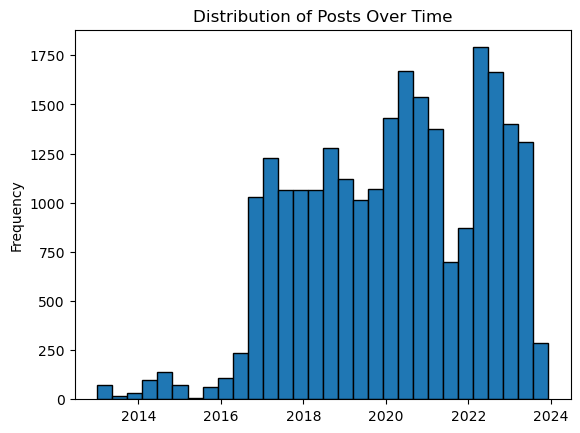

In [19]:
#Create histogram to view distribution of posts over time
df['Date'].hist(bins=30, edgecolor='k')
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Distribution of Posts Over Time')
plt.grid(False)

### Correlation Between Features

<AxesSubplot:>

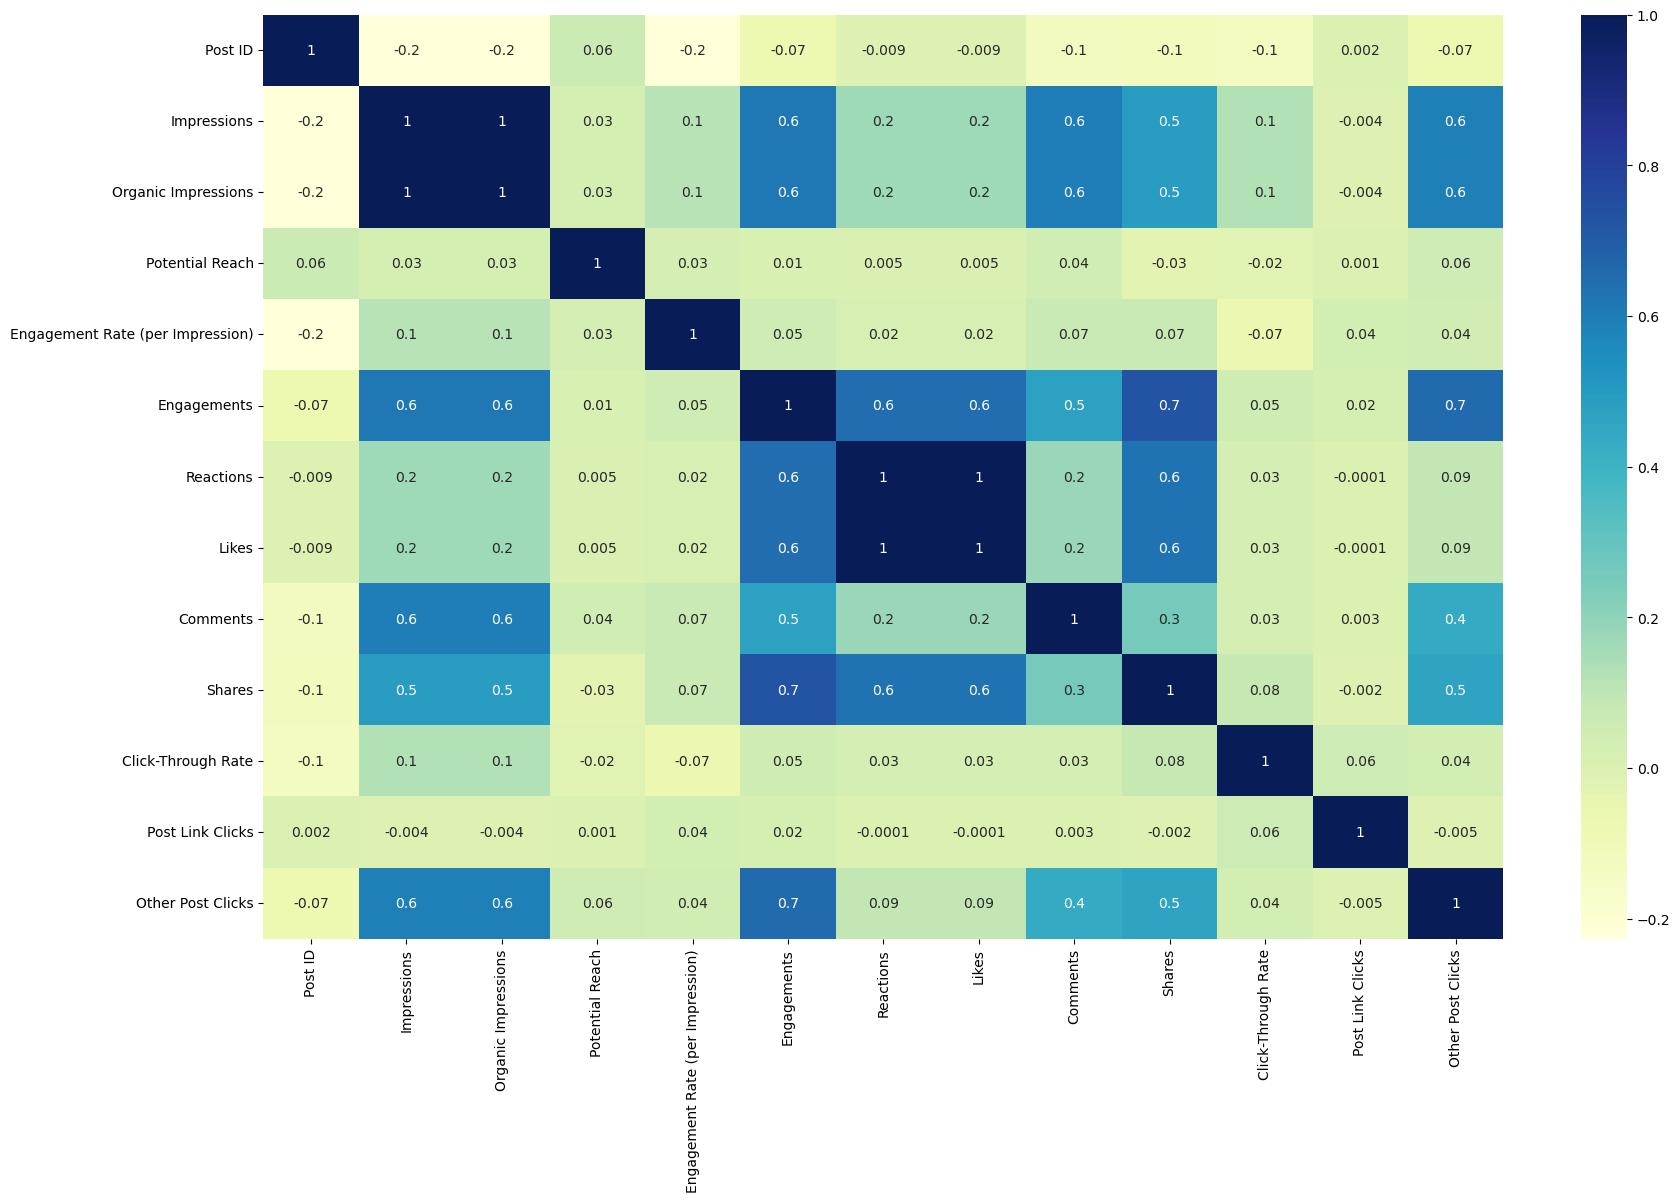

In [20]:
# Correlation matrix and heatmap
corr_matrix = df.iloc[:, :22].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.1g')

<AxesSubplot:>

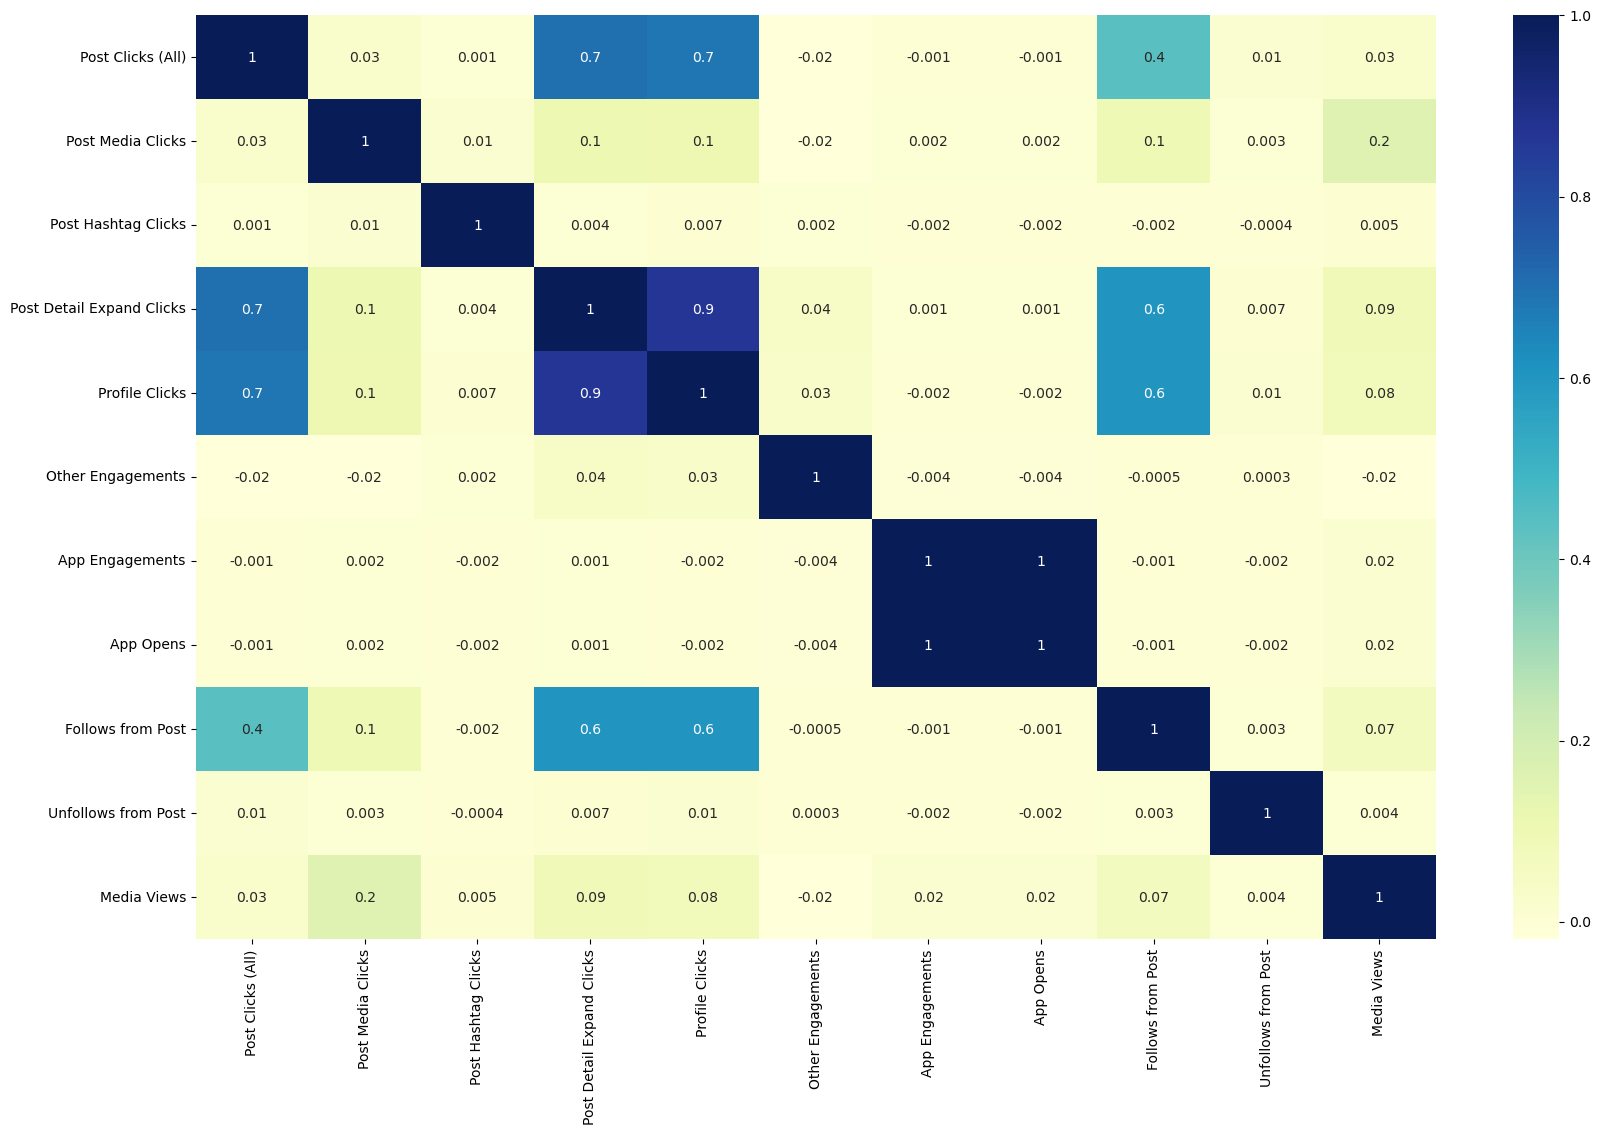

In [21]:
# Correlation matrix and heatmap
corr_matrix = df.iloc[:, 22:].corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.1g')

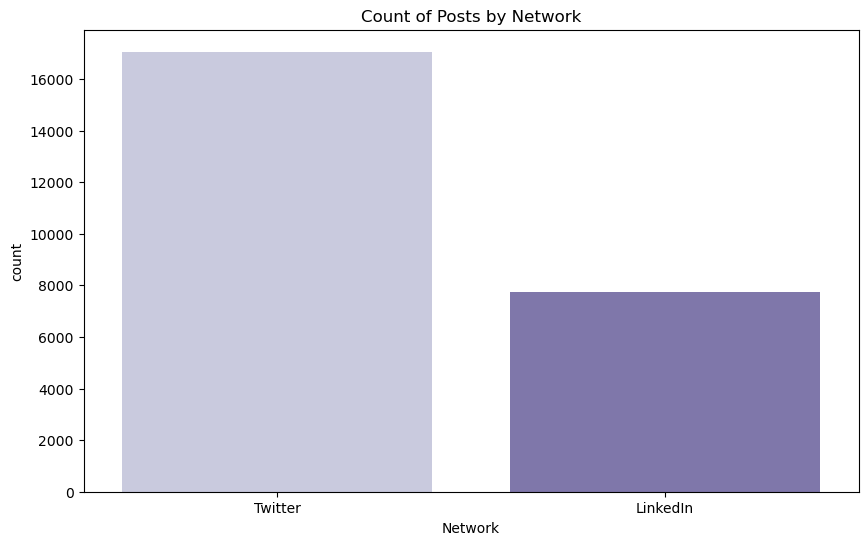

In [22]:
#Count Plot of Posts By Network
plt.figure(figsize=(10, 6))
sns.countplot(x='Network', data=df, palette = 'Purples')
plt.title('Count of Posts by Network');

In [23]:
# Feature Engineering
# Extract day of the week and hour of the day from the 'Date' column
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Hour_of_Day'] = df['Date'].dt.hour

# Extract the month and year from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Create feature to check if Posts contain hashtags or not
df['Hashtags'] = df_copy['Post'].str.contains('#', regex=False)


# Define a mapping dictionary for month names
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
    6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November',12: 'December'
}

#Create list of months in the correct order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]


# create a new feature with month names
df['Month_Name'] = df['Month'].map(month_mapping)
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

#Resample the data to monthly data
df_monthly = df.set_index('Date').resample('M').sum()

#Apply log transformation
df_monthly['log_engagements'] = np.log1p(df_monthly['Engagements'])
df['log_engagements'] = np.log1p(df['Engagements'])
df.fillna(method='bfill', inplace = True)

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
#Save data after feature engineering
#Dataframe after preprocessing and cleaning
#csv file
df.to_csv('features_added.csv', index = False)

#Excel file
df.to_excel('features_added.xlsx', sheet_name = 'main_sheet', index = False)

### Are There Any Trends Over Time?

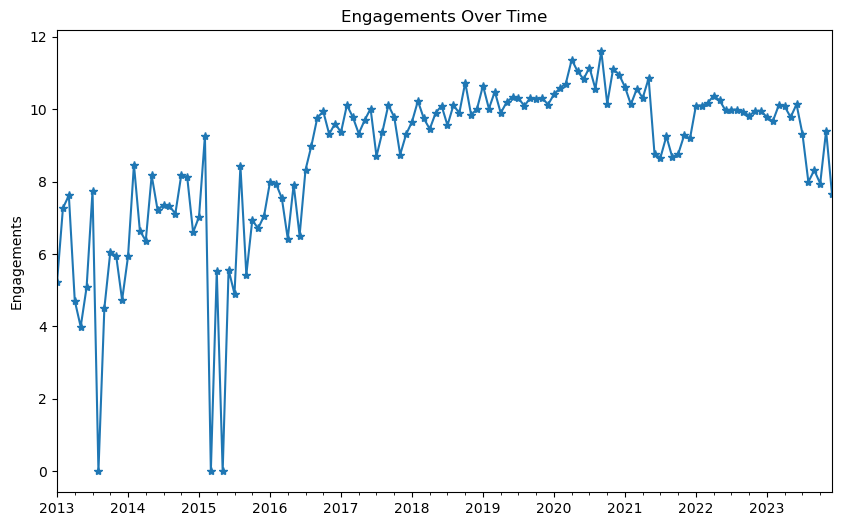

In [25]:
# Group data by date and calculate daily total engagements
daily_engagements = df_monthly.groupby('Date')['log_engagements'].sum()

# Create a line plot to visualize trends over time
plt.figure(figsize=(10, 6))
daily_engagements.plot(title='Engagements Over Time', marker = '*')
plt.xlabel('')
plt.ylabel('Engagements');


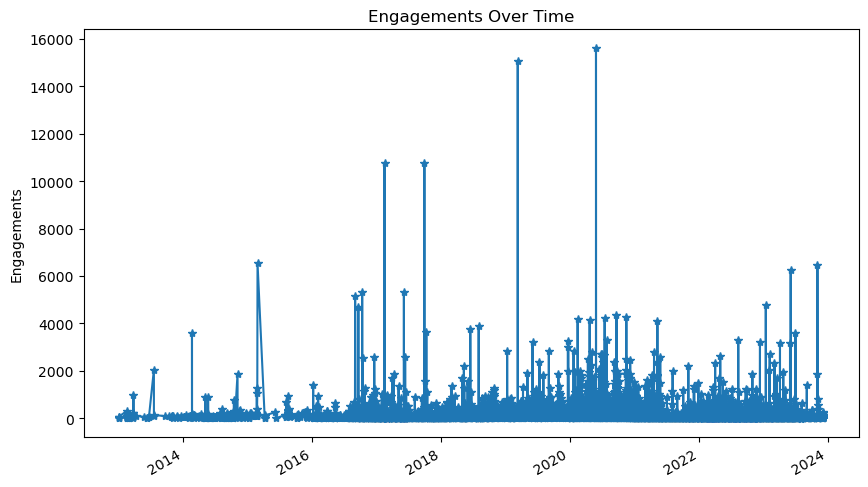

In [26]:
# Group data by date and calculate daily total engagements
daily_engagements = df.groupby('Date')['Engagements'].sum()

# Create a line plot to visualize trends over time
plt.figure(figsize=(10, 6))
daily_engagements.plot(title='Engagements Over Time', marker = '*')
plt.xlabel('')
plt.ylabel('Engagements');


### Is The Data Stationary Or Not

In [27]:
#We perform augmented Dickey - Fuller test to check if data is stationary or not
adfuller(df['Engagements'])

(-15.669565858826651,
 1.5186408675097521e-28,
 34,
 24783,
 {'1%': -3.4306138896601888,
  '5%': -2.861656631195098,
  '10%': -2.5668320793827957},
 346092.6675033669)

From the Augmented Dickey - Fuller test, the **p-value(1.5186408675097521e-28)** obtained is less than 0.05 therefore the feature 'Engagements' is not stationary, this implies that the statistical properties do not change over time.

## Analysis and Insights

### Top Posts By Engagement Rate

In [28]:
top_posts = df_copy.sort_values(by='Engagement Rate (per Impression)', ascending=False).head(5)[['Date', 'Network', 'Post', 'Engagement Rate (per Impression)', 'Link']]
print('-'* 120)
print('Top Posts By Engagement Rate')
print('-' * 120)
top_posts = top_posts.style.background_gradient()
dfi.export(top_posts,"TopPostsByEngagements.png")
top_posts

------------------------------------------------------------------------------------------------------------------------
Top Posts By Engagement Rate
------------------------------------------------------------------------------------------------------------------------


### Which Social Media Network Performs Best?

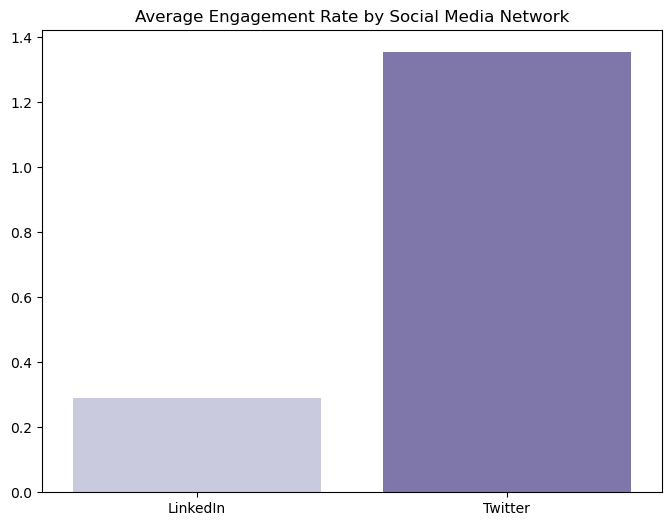

In [29]:
net_eng = df.groupby('Network')['Engagement Rate (per Impression)'].mean()
plt.figure(figsize=(8,6))
sns.barplot(x = net_eng.index, y = net_eng.values, palette = 'Purples')
plt.title('Average Engagement Rate by Social Media Network')
plt.xlabel('');

There are 2 social media platforms considered in this data, from the chat above we see that users were far more engaged on Tweeter than on LinkedIn

### When Are Peak Engagement Times?

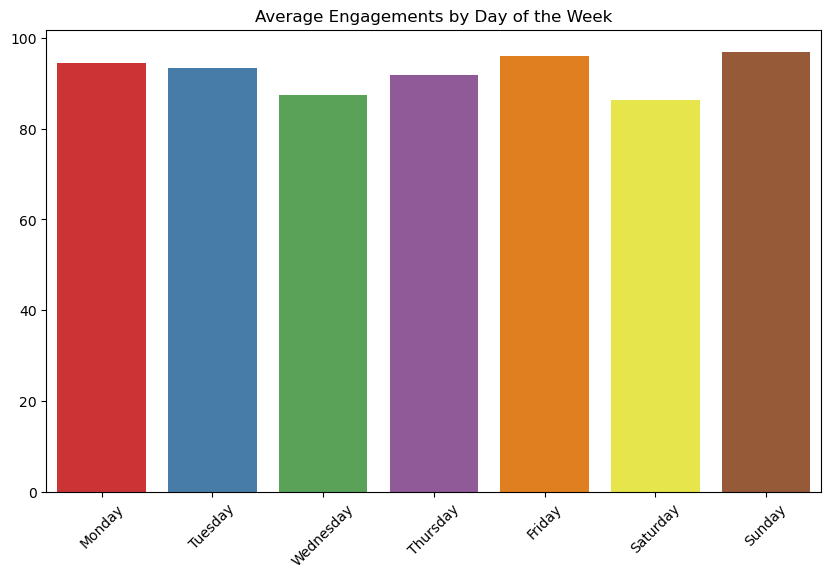

In [30]:
# Calculate average engagements by day of the week
dow_engagement = df.groupby('Day_of_Week')['Engagements'].mean()

# Create a bar plot to visualize peak engagement times by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x = dow_engagement.index, y =dow_engagement.values, palette = 'Set1',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Engagements by Day of the Week')
plt.xlabel('')
plt.xticks(rotation=45);


Users of the social networks(Twitter and LinkedIn) in the given dataset were most active on Friday and Sunday and were least active on wednesday.

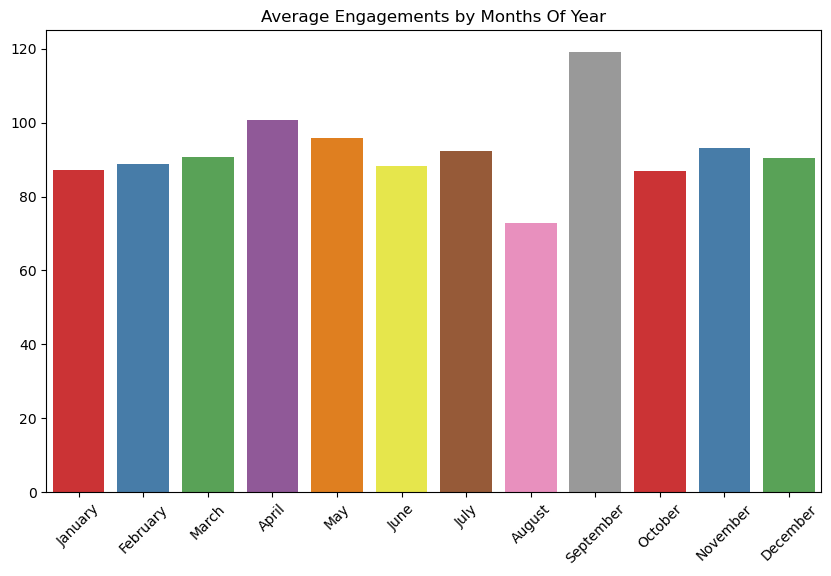

In [31]:
# Calculate average engagements by month of the year
moy_engagement = df.groupby('Month_Name')['Engagements'].mean()

# Create a bar plot to visualize peak engagement times by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x = moy_engagement.index, y =moy_engagement.values, palette = 'Set1')
plt.title('Average Engagements by Months Of Year')
plt.xlabel('')
plt.xticks(rotation=45);

Users of the social network in this dataset were most active in September followed by April and were least active in August.

### What Is the Relationship Between Impressions and Engagement?

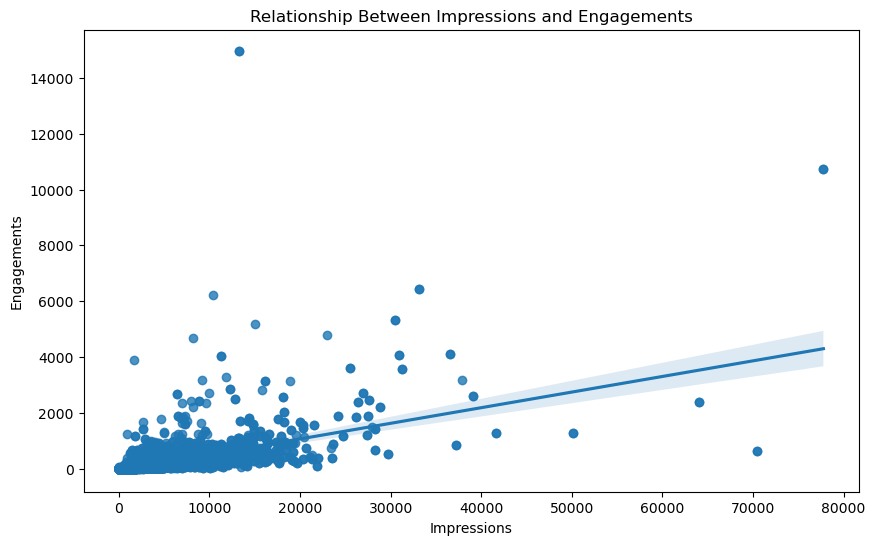

In [32]:
# Regression plot to visualize the relationship between impressions and engagements
plt.figure(figsize=(10, 6))
sns.regplot(x='Impressions', y='Engagements', data=df)
plt.title('Relationship Between Impressions and Engagements')
plt.xlabel('Impressions')
plt.ylabel('Engagements')
plt.show()


From the regression plot above, we notice that there is a linear relationship between the number of engagements and number of impressions. Furthermore, there is a positive correlation between the number of engagements and the number of impressions, indicating that when there is an increase in the number of impressions, there tends to be an increase in the number of engagements. However, it's important to note that correlation does not establish a causal relationship, and other factors may also contribute to changes in engagement.

### Which Content Types Receive the Most Shares?

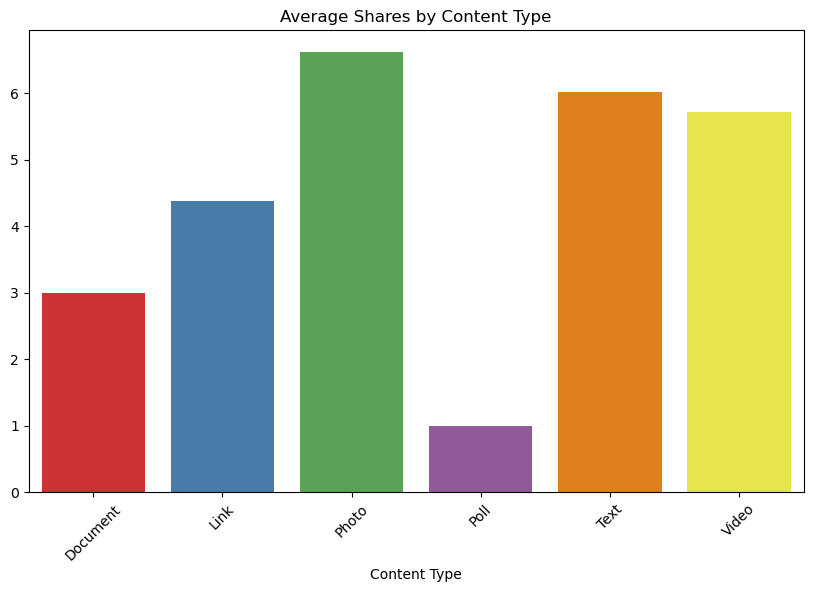

In [33]:
# Calculate average shares by content type
content_type_shares = df.groupby('Content Type')['Shares'].mean()

# Create a bar plot to visualize content type performance
plt.figure(figsize=(10, 6))
sns.barplot(x=content_type_shares.index, y=content_type_shares.values, palette = 'Set1')
plt.title('Average Shares by Content Type')
plt.xticks(rotation=45);


From the visualisation above, posts that contains photos recieved the most amount of shares, closely followed by posts that contains text while posts that contains poll had the least amount of shares.

### How Effective Are Hashtags in Driving Engagement?

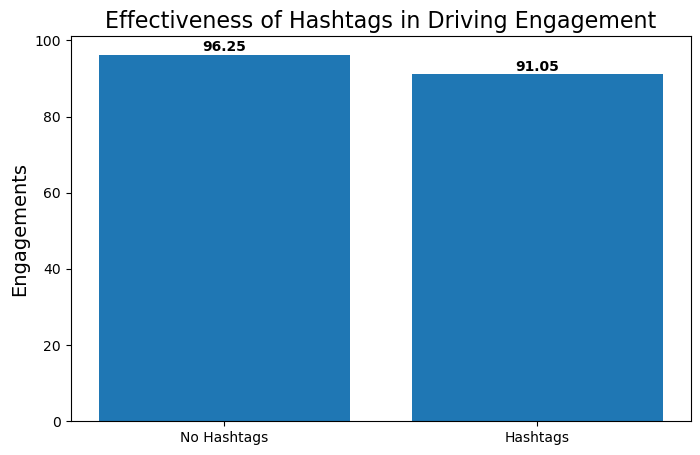

In [34]:
# Calculate the average engagement for posts with and without hashtags
hash_eff = df.groupby('Hashtags')['Engagements'].mean()

# Create a bar plot to visualize hashtag effectiveness
pct = np.round(hash_eff.values,2)
plt.figure(figsize=(8, 5))
bar = plt.bar(x = hash_eff.index, height=hash_eff.values)
plt.title('Effectiveness of Hashtags in Driving Engagement', size = 16)
plt.xticks([0, 1], ['No Hashtags', 'Hashtags'])
plt.xlabel('')
plt.ylabel('Engagements', size = 14)

i = 0
for p in bar:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height*1.01, pct[i],ha='center', weight='bold')
    i+=1

The mean number of engagements for posts without hashtags is higher than posts with hashtags, this implies that according to the data, hashtags are ineffective in driving engagements.

### How Do Different Types of Clicks Correlate with Engagement?

In [35]:
#Get the features with Clicks in their names
click_columns = [x for x in df.columns if 'Clicks' in x]

print('-'*120)
print('-'*120)
print('Correlation between Types of Clicks with Engagement')
print('-'*120)
print('')

for click_col in click_columns:
    spearman_corr, p_value = spearmanr(df[click_col], df['Engagements'])
    print('The Spearman correlation co-efficient for {} is {} while the p-value is given by {}'.format(click_col, spearman_corr, p_value))

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Correlation between Types of Clicks with Engagement
------------------------------------------------------------------------------------------------------------------------

The Spearman correlation co-efficient for Post Link Clicks is 0.060636515712997344 while the p-value is given by 1.168167181072936e-21
The Spearman correlation co-efficient for Other Post Clicks is 0.609226128282498 while the p-value is given by 0.0
The Spearman correlation co-efficient for Post Clicks (All) is 0.9515994456148669 while the p-value is given by 0.0
The Spearman correlation co-efficient for Post Media Clicks is 0.12401143483690517 while the p-value is given by 1.2411177830822533e-85
The Spearman correlation co-efficient for Post Hashtag Clicks is -0.04225479796974

We use Spearman Rank Correlation to determine the association(correlation) between the different types of clicks with the engagement feature, from the above output, we have that there is strong positive correlation between Post Clicks (All) and Engagement, since the p-value is less than 0.05 then the correlation is statistically significant. Therefore an increase in the number of Post Clicks (All) results in an increase in the number of engagements

There is also a strong positive correlation between Post Link Clicks, Other Post Clicks and Engagement, although less than that of Post Clicks(All) and Engagement, their p-values are also less than 0.05 which implies statistical significance. Therefore that increase in Post Link Clicks, Other Post Clicks results in an increase in number of Engagements

There is a weak positive correlation between between Post Media Clicks and Engagements and moderately strong positive correlation between Post Detail Expand Clicks, Profile Clicks and Engagements.

Finally, there is a weak negative correlation between Post Hashtag Clicks and Engagements 

We note that all the p-values are all less than 0.05 which implies that the correlations are all statistically significant.

### Is There a Seasonal or Periodic Pattern in Engagement?

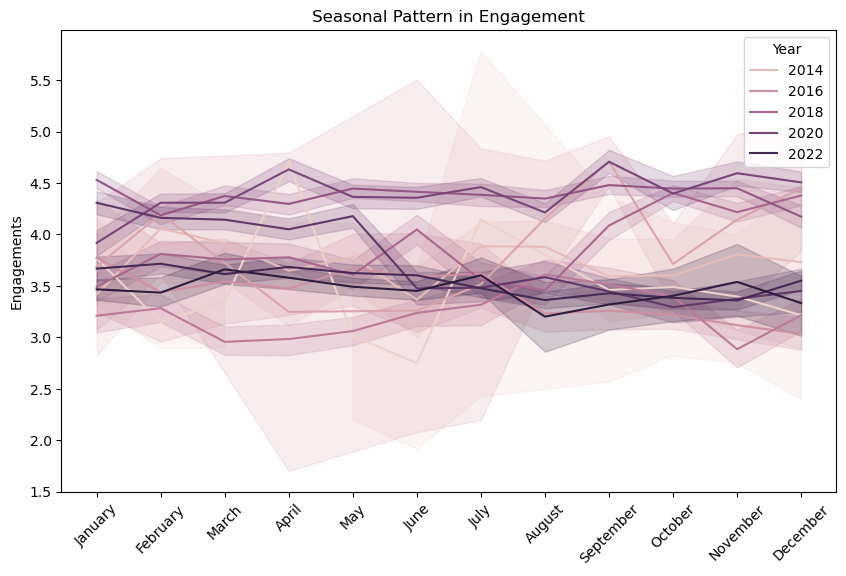

In [36]:
# Line plot to visualize engagement over time 
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month_Name', y='log_engagements', hue='Year', data=df)
plt.title('Seasonal Pattern in Engagement')
plt.xlabel('')
plt.ylabel('Engagements')
plt.legend(title='Year')
plt.xticks(rotation = 45);

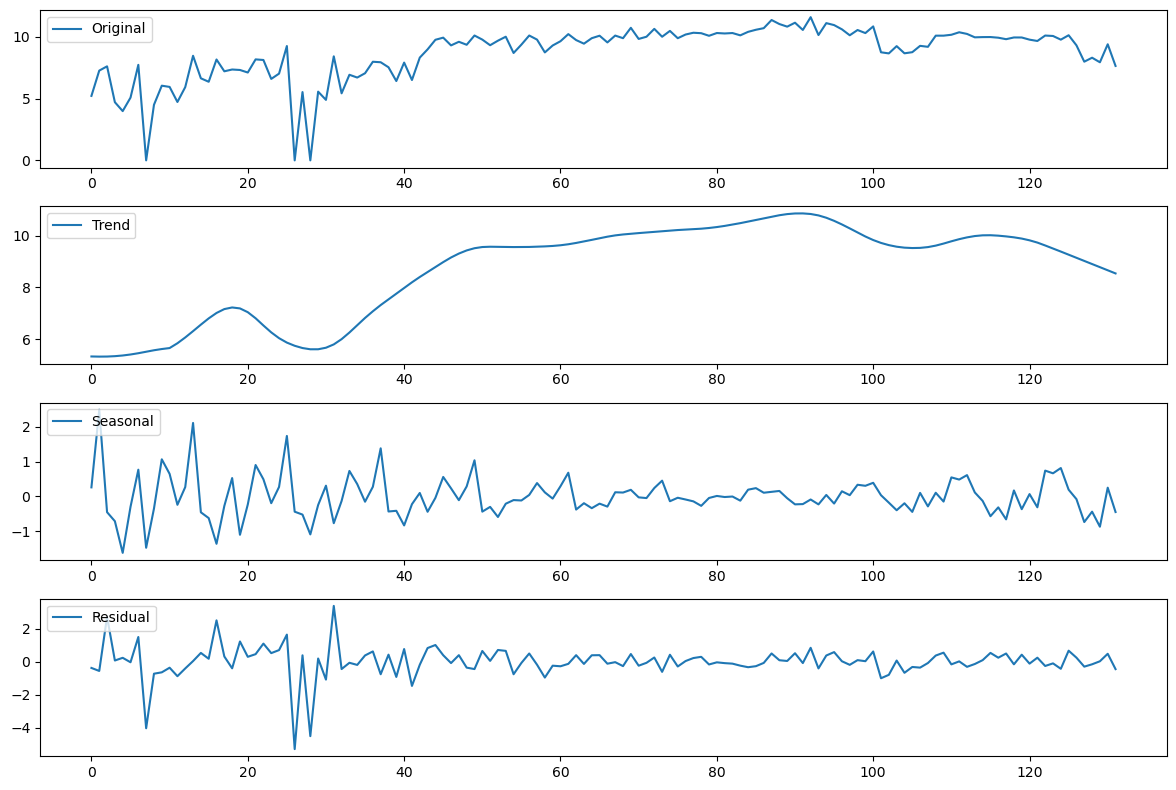

In [37]:
season_check = df_monthly[ 'log_engagements']
decomposition = STL(season_check.values, seasonal=13, period=12).fit()
seasonal, trend, residual = decomposition.seasonal, decomposition.trend, decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(season_check.values, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


### What Is the Overall Engagement Rate and How Does It Vary Across Platforms?

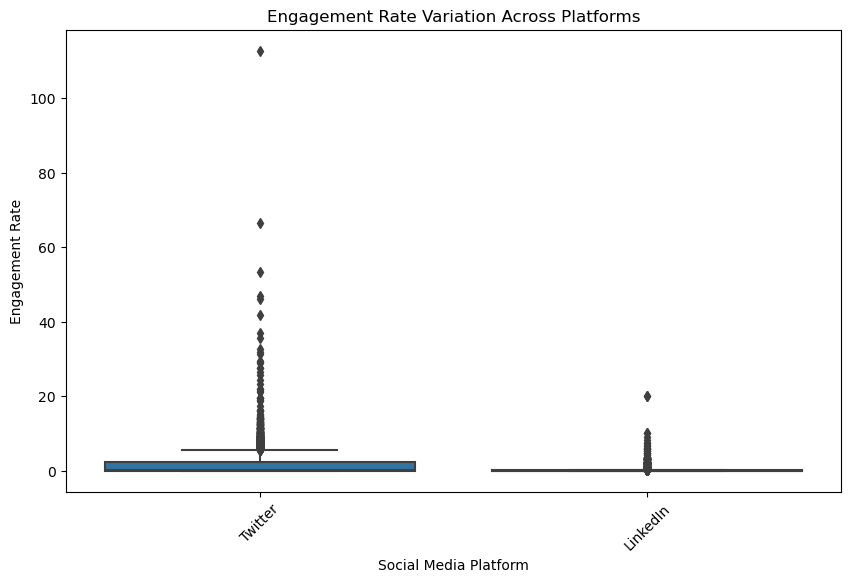

In [38]:
# Box plot to visualize the distribution of engagement rates by platform
plt.figure(figsize=(10, 6))
sns.boxplot(x='Network', y='Engagement Rate (per Impression)', data=df)
plt.title('Engagement Rate Variation Across Platforms')
plt.xlabel('Social Media Platform')
plt.ylabel('Engagement Rate')
plt.xticks(rotation=45)
plt.show()


### Most Used Words in Social Media Posts

(-0.5, 599.5, 599.5, -0.5)

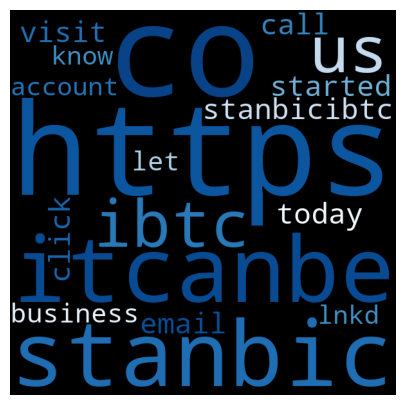

In [39]:
words = []
for i in df['Post']:
    word = word_tokenize(i)
    for j in word:
        words.append(j)
freq_word = nltk.FreqDist(words)



most_common = pd.DataFrame(freq_word.most_common(20), columns = ['Word', 'Frequency']).set_index('Word')


text=' '.join(most_common.index)
plt.figure(figsize = (9,5))
words = WordCloud(background_color='black', colormap='Blues', include_numbers=True,
                    width=600, height=600).generate(text)
plt.imshow(words)
plt.axis("off")


From the visualisation above, we can see the most commonly used words excluding **stopwords** in the posts. Frequently used words in posts includes but are not restricted to "visit", "call", "let", "today", e.t.c.